In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
test_lungs = open("test_images_lungs.txt",'r').read().splitlines()
test_heart = open("test_images_heart.txt",'r').read().splitlines()

In [3]:
from models.HybridGNet2IGSC import Hybrid 
from models.PCA import PCA_Net
from models.FC import FC

import os 
import numpy as np
from torchvision import transforms
import torch

from utils.utils import scipy_to_torch_sparse, genMatrixesLungs, genMatrixesLungsHeart
import scipy.sparse as sp
from utils.dataset import LandmarksDataset, ToTensor, RandomScale, AugColor, Rotate

In [4]:
dataset = LandmarksDataset(test_heart,
                           img_path = "../Chest-xray-landmark-dataset/Images",
                           label_path = "../Chest-xray-landmark-dataset/landmarks",
                           heart = True,
                           transform = ToTensor()
                           )

device = 'cuda:0'

In [5]:
A, AD, D, U = genMatrixesLungsHeart()

N1 = A.shape[0]
N2 = AD.shape[0]

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]

config = {}

config['n_nodes'] = [N1, N1, N1, N2, N2, N2]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

hybrid = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
hybrid.load_state_dict(torch.load("Training/Hybrid/bestMSE.pt"))
hybrid.eval()
print('Model loaded')

Model loaded


In [6]:
from models.PCA import PCA_Net

config['device'] = device
config['Lungs'] = False

pcaNet = PCA_Net(config.copy()).to(device)
pcaNet.load_state_dict(torch.load('Training/PCA/bestMSE.pt'))
pcaNet.eval()
print('Model loaded')

Model loaded


In [7]:
from models.FC import FC

fc = FC(config.copy()).to(device)
fc.load_state_dict(torch.load('Training/FC/bestMSE.pt'))
fc.eval()
print('Model loaded')

Model loaded


In [8]:
from medpy.metric import dc, hd
import cv2

def getDenseMask(RL, LL, H = None, imagesize = 1024):
    img = np.zeros([1024,1024])
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 1, -1)
    
    if H is not None:
        H = H.reshape(-1, 1, 2).astype('int')
        img = cv2.drawContours(img, [H], -1, 2, -1)
    
    return img


def evalImageMetrics(output, target):
    dcp = dc(output == 1, target == 1)
    dcc = dc(output == 2, target == 2)
    
    hdp = hd(output == 1, target == 1)
    hdc = hd(output == 2, target == 2)
        
    return [dcp, dcc, hdp, hdc]

In [13]:
import pandas as pd
from sklearn.metrics import mean_squared_error

model_list = [pcaNet, fc, hybrid]
model_names = ['PCA', 'FC', 'HybridGNet']

results = pd.DataFrame()

for i in range(0, len(dataset.images)):
    print('\r',i+1,'of', len(dataset.images),end='')
    with torch.no_grad():
        sample = dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1,2).numpy()
        
        RL = target[:44] * 1024
        LL = target[44:94] * 1024
        H = target[94:] * 1024
        
        targetseg = getDenseMask(RL, LL, H)
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            output = output.cpu().numpy().reshape(-1, 2) 
            mse = mean_squared_error(output.reshape(-1) * 1024, target.reshape(-1) * 1024)
            
            RL = output[:44] * 1024
            LL = output[44:94] * 1024
            H = output[94:] * 1024

            outseg = getDenseMask(RL, LL, H)
        
            metrics = evalImageMetrics(outseg, targetseg)
             
            aux = pd.DataFrame([[i, model_names[j], mse] + metrics], columns=['i','Model','MSE', 'Dice Lungs','Dice Heart','HD Lungs','HD Heart'])
            results = results.append(aux, ignore_index = True)

 76 of 76

In [14]:
sub = results
del sub['i']
sub.groupby('Model').mean()

,MSE,Dice Lungs,Dice Heart,HD Lungs,HD Heart
Model,,,,,
FC,359.423800,0.938108,0.907268,50.506582,44.751405
HybridGNet,220.685126,0.965563,0.933040,37.550593,35.982695
PCA,359.696809,0.938072,0.909292,50.469137,43.823793


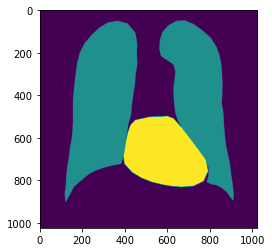

In [15]:
from utils.utils import drawOrgans
import matplotlib.pyplot as plt

plt.imshow(outseg)

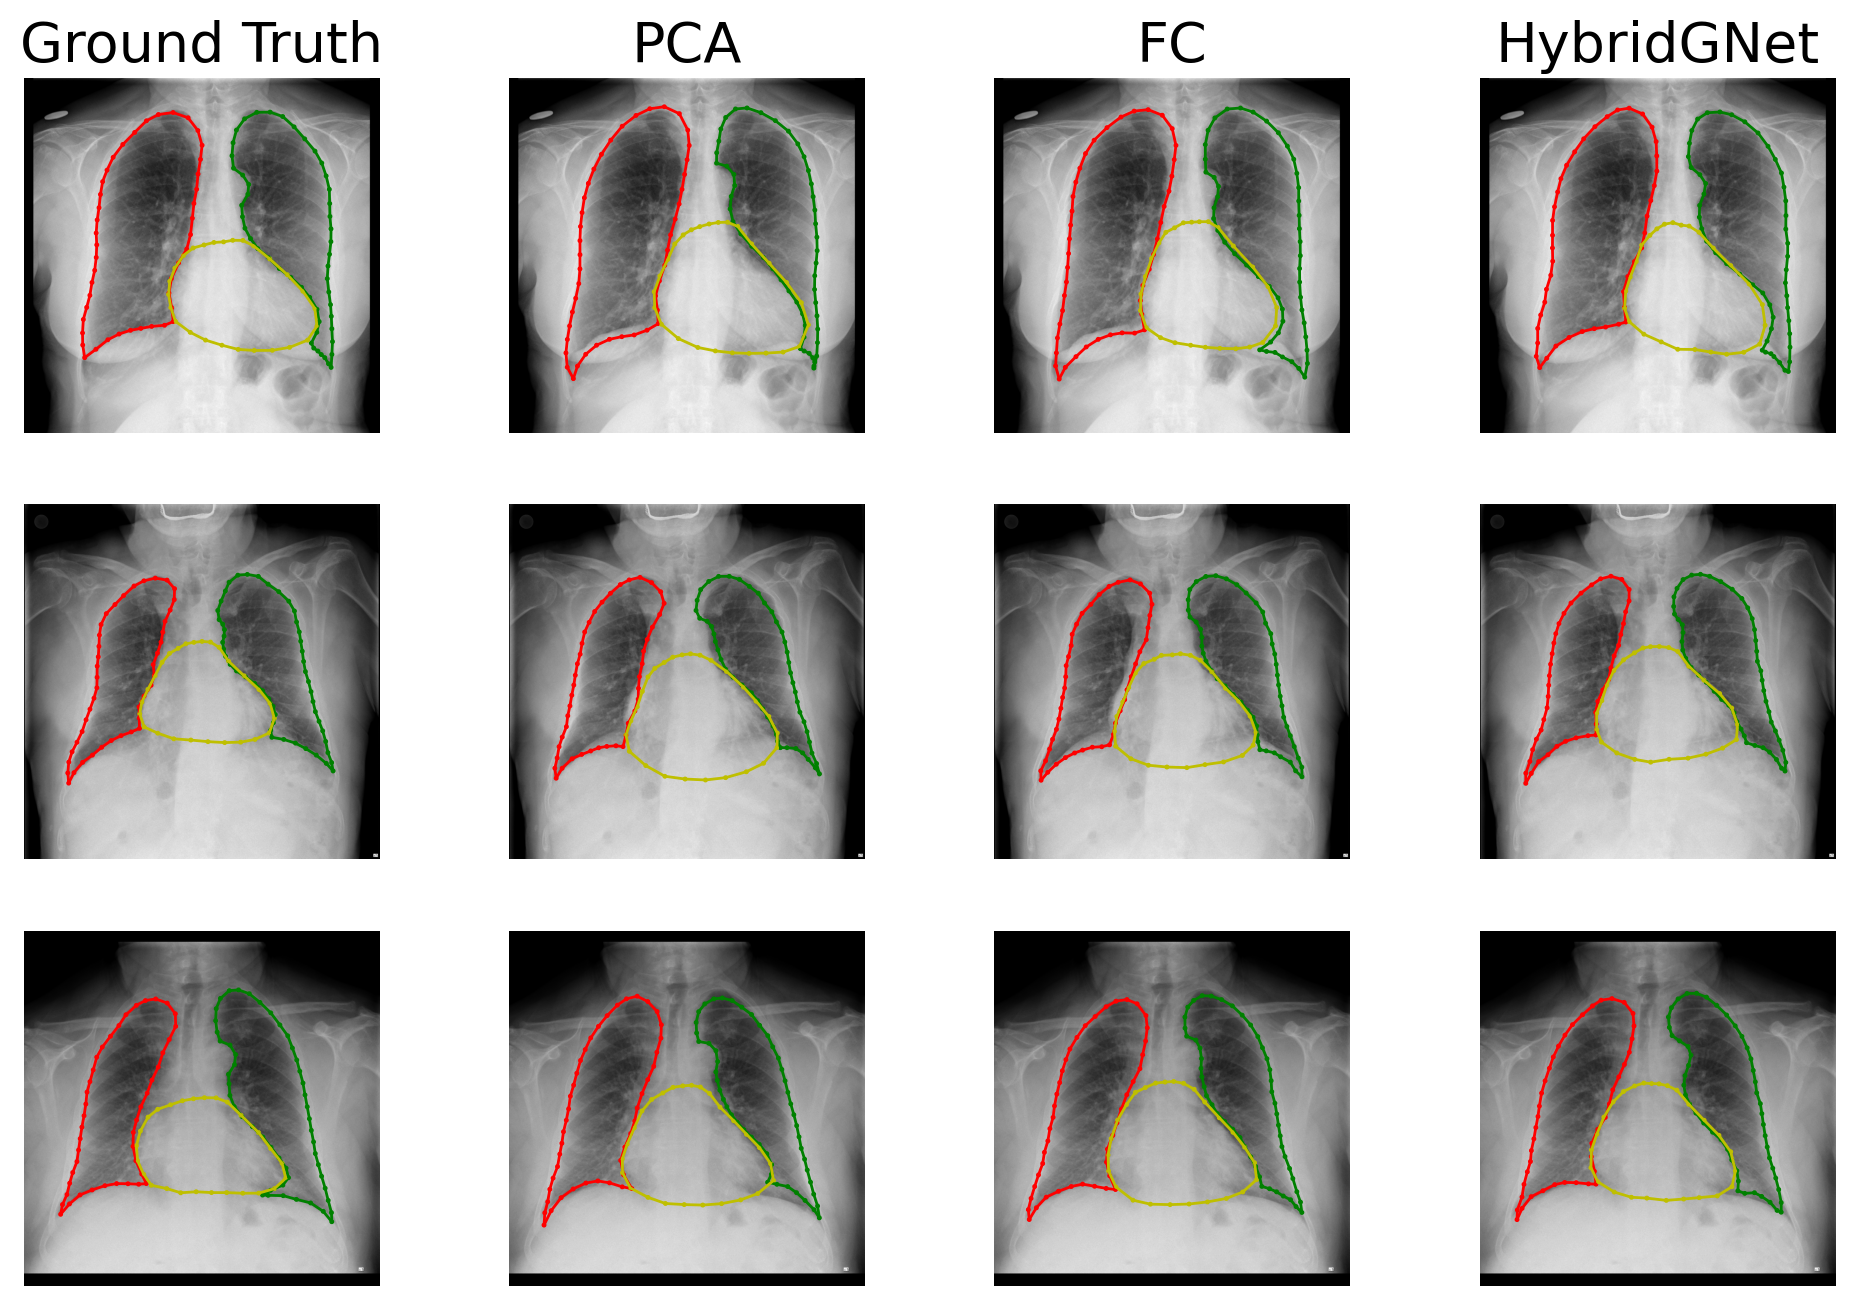

In [16]:
i_ =[0, 10, 20]

fig = plt.figure(figsize=(12, 8), dpi= 200)

c = 0

for i in i_:
    with torch.no_grad():
        sample = dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target = target.numpy()

        RL = target[:44] * 1024
        LL = target[44:94] * 1024
        H = target[94:] * 1024

        draw = data.cpu().numpy()[0,0,:,:]
        
        ax = plt.subplot(3, len(model_list) + 1, c * (len(model_list) + 1) + 1)
        plt.axis('off')
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
        target = np.clip(target, 0, 1)
        if c == 0:
            plt.title("Ground Truth", fontsize = 20)
        drawOrgans(RL,LL,H, draw.copy(), ax)    
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1,2)
            
            RL = output[:44] * 1024
            LL = output[44:94] * 1024
            H = output[94:] * 1024
        
            ax = plt.subplot(3, len(model_list) + 1, j + 2 + c * (len(model_list) + 1))
            plt.axis('off')
            if c == 0:
                plt.title(model_names[j], fontsize = 20)

            drawOrgans(RL,LL,H, draw.copy(), ax)  
            plt.xlim(1, 1024)
            plt.ylim(1024, 1)
        
        c += 1